In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from binance.client import Client
from datetime import datetime, timedelta
%matplotlib inline

# Channel Breakout Strategy
## Rules:
#### Long:
* if today's close is the highest close of last 40 days go long
* if long and today's close is the lowest close of last 20 days go neutral(exit long position)
#### Short:
* if today's close is the lowest close of last 40 days go short
* if short and today's close is the highest close of last 20 days go neutral(exit short position)

## Class for strategy report(WORKFLOW)

In [140]:
class backtest_strategy():
    def __init__(self, client, symbol, train_start, train_end,
                 test_start, test_end, entry_signals, exit_signals,
                 interval="1d", data_source=None):
        self.data_source = data_source
        self.symbol = symbol
        self.train_start = str(train_start)
        self.train_end = str(train_end)
        self.test_start = str(test_start)
        self.test_end = str(test_end)
        self.entry_signals = entry_signals
        self.exit_signals = exit_signals
        self.interval = interval
        self.client = client
    def get_candles(self):
        import os.path
        if os.path.isfile("{}.csv".format(self.symbol)) :
            self.raw = pd.read_csv("{}.csv".format(self.symbol), parse_dates=[0])
            self.raw.set_index("date", inplace=True)
        else:
            earliest_timestamp = self.client._get_earliest_valid_timestamp(symbol=self.symbol,
                                                                          interval=self.interval)
            earliest_timestamp = pd.to_datetime(earliest_timestamp, unit="ms")
            self.raw = client.get_historical_klines(symbol=self.symbol, interval=self.interval,
                                                     start_str=str(earliest_timestamp))
            self.raw = pd.DataFrame(self.raw)
            self.raw.drop(list(range(6,12,1)), axis=1, inplace=True)
            column_names = ["date","open", "high","low","close","volume"]
            self.raw.columns = column_names
            self.raw["date"] = pd.to_datetime(self.raw["date"], unit="ms")
            self.raw.set_index("date", inplace=True)
            for col in self.raw.columns:
                self.raw[col] = pd.to_numeric(self.raw[col])
            self.raw.to_csv("{}.csv".format(self.symbol))
        self.train_data = self.raw.loc[self.train_start:self.train_end].copy()
        self.test_data = self.raw.loc[self.test_start:self.test_end].copy()
    def strategy(self):
        from itertools import product
        combinations = product(self.entry_signals, self.exit_signals)
        self.sharpe_of_combinations = []
        #-----------------------------STRATEGY FIELD  (DYNAMIC)------------------------------------
        close = self.train_data.close.to_frame().copy()
        close.rename(columns={"close":"price"}, inplace=True)
        for combination in combinations:
            close["last_n_dayhigh_longtrade"] = close.price.rolling(window=combination[0]).max().shift()
            close["last_n_daylow_longtrade"] = close.price.rolling(window=combination[1]).min().shift()
            close["last_n_daylow_shorttrade"] = close.price.rolling(window=combination[0]).min().shift()
            close["last_n_dayhigh_shorttrade"] = close.price.rolling(window=combination[1]).max().shift()
            temp = close.copy()
            temp["long_entry"] = np.where(temp.price.shift() > temp["last_n_dayhigh_longtrade"].shift(), 1, 0)
            temp["long_exit"] = np.where(temp.price.shift() < temp["last_n_daylow_longtrade"].shift(), 1, 0)
            temp["short_entry"] = np.where(temp.price.shift() < temp["last_n_daylow_shorttrade"].shift(), 1, 0)
            temp["short_exit"] = np.where(temp.price.shift() > temp["last_n_dayhigh_shorttrade"].shift(), 1, 0)
            trades = pd.DataFrame()
            trades[["long_entry", "long_exit", "short_entry", "short_exit"]] = temp.loc[(temp.long_entry==1)|(temp.short_entry==1)|(temp.long_exit==1)|(temp.short_exit==1), ["long_entry", "long_exit", "short_entry", "short_exit"]]
            trades = trades[(trades.long_entry.diff()==1)|(trades.short_entry.diff()==1)|(trades.long_exit.diff()==1)|(trades.short_exit.diff()==1)]
            long_entry_dates = []
            long_exit_dates = []
            short_entry_dates = []
            short_exit_dates = []
            long_inpos=False
            short_inpos=False
            for i in range(len(trades)):
                if trades.iloc[i].long_entry==1:
                    if long_inpos==False and short_inpos==False:
                        long_entry_dates.append(trades.index[i])
                        long_inpos=True
                if trades.iloc[i].long_exit==1:
                    if long_inpos==True:
                        long_exit_dates.append(trades.index[i])
                        long_inpos=False
                if trades.iloc[i].short_entry==1:
                    if long_inpos==False and short_inpos==False:
                        short_entry_dates.append(trades.index[i])
                        short_inpos=True
                if trades.iloc[i].short_exit==1:
                    if short_inpos==True:
                        short_exit_dates.append(trades.index[i])
                        short_inpos=False
            if len(long_entry_dates) > len(long_exit_dates):
                long_entry_dates.pop(-1)
            if len(short_entry_dates) > len(short_exit_dates):
                short_entry_dates.pop(-1)
            close["long_position"] = 0
            close["short_position"] = 0
            long_inposition_intervals = []
            short_inposition_intervals = []
            for i in range(len(long_entry_dates)):
                long_inposition_intervals.append([long_entry_dates[i], long_exit_dates[i]])
            for long_inposition_interval in long_inposition_intervals:
                close.loc[long_inposition_interval[0]:long_inposition_interval[1], "long_position"] = 1
            for i in range(len(short_entry_dates)):
                short_inposition_intervals.append([short_entry_dates[i], short_exit_dates[i]])
            for short_inposition_interval in short_inposition_intervals:
                close.loc[short_inposition_interval[0]:short_inposition_interval[1], "short_position"] = 1
            #commission = np.log(1 - 0.001) + np.log(1 - 0.0002)
            close["log_ret"] = np.log(close.price.pct_change() + 1)
            close["strategy_returns"] = (close.log_ret * close.long_position) + (-1 * close.log_ret * close.short_position)
            close["trades"] = (close.long_position + close.short_position).to_frame().diff()
            #close.loc[close.trades!=1, "trades"] = 0
            #close["strategy_returns_wcomissions"] = close.strategy_returns - (close.trades * commission)
            self.sharpe_of_combinations.append(self.evaluate(close, combination))
        #------------------------------------------------------------------------------------------
    def evaluate(self, prepared_data, combination):
        trading_days = (365.25 * 24)
        strategy_ann_mu = prepared_data.strategy_returns.mean() * (trading_days)
        strategy_ann_std = prepared_data.strategy_returns.std() * np.sqrt(trading_days)
        sharpe_ratio = strategy_ann_mu / strategy_ann_std
        return list(list(combination) + [sharpe_ratio])
    def report(self):
        report_df = pd.DataFrame(columns=["entry", "exit", "sharpe"])
        for sharpe_n_combination in self.sharpe_of_combinations:
            report_df.loc[len(report_df)] = sharpe_n_combination
        return report_df

In [141]:
api_key = "bT3JgDAiGkPkIDzVAGNXvRrLU5PePQz0kNz2Gtt8NFAatjfOOIiVoiMhjOk4t9RL"
secret_api_key = "IdrL486SQzb5QB5ruuakUZZdKwgTNGGEzM1VHQ6QPDSpZawrGCemjV1LNfOYCjWj"
client = Client(api_key=api_key, api_secret=secret_api_key, tld="com")

In [142]:
timestamp = client._get_earliest_valid_timestamp(symbol="BTCUSDT", interval="1h")
timestamp = pd.to_datetime(timestamp, unit="ms")
timestamp

Timestamp('2017-08-17 04:00:00')

In [143]:
train_end = "2020-08-17"
test_start = "2020-08-17"
test_end = "2022-09-07"

In [160]:
backtester = backtest_strategy(client, symbol="BTCUSDT", train_start=timestamp, train_end=train_end,
                              test_start=test_start, test_end=test_end,entry_signals=[40,60,80,100,120,140,160,200,400],
                              exit_signals=[20,30,40,50,60,70,80,100,200], interval="1h")

In [161]:
backtester.get_candles()

In [162]:
backtester.strategy()

In [166]:
sharpes = backtester.report()

In [168]:
sharpes

,entry,exit,sharpe
0,40.0,20.0,1.490671
1,40.0,30.0,1.169476
2,40.0,40.0,0.632446
3,40.0,50.0,0.669440
4,40.0,60.0,0.501015
...,...,...,...
76,400.0,60.0,0.873125
77,400.0,70.0,0.738978
78,400.0,80.0,0.706298
79,400.0,100.0,0.859464


In [171]:
sharpes.nlargest(columns="sharpe", n=10)

,entry,exit,sharpe
0,40.0,20.0,1.490671
9,60.0,20.0,1.362350
64,200.0,30.0,1.356472
10,60.0,30.0,1.289344
55,160.0,30.0,1.273581
63,200.0,20.0,1.230032
46,140.0,30.0,1.202394
65,200.0,40.0,1.178967
54,160.0,20.0,1.176503
28,100.0,30.0,1.170951


# Free coding trying out how to implement the strategy
### Using binance as the data source

In [3]:
api_key = "bT3JgDAiGkPkIDzVAGNXvRrLU5PePQz0kNz2Gtt8NFAatjfOOIiVoiMhjOk4t9RL"
secret_api_key = "IdrL486SQzb5QB5ruuakUZZdKwgTNGGEzM1VHQ6QPDSpZawrGCemjV1LNfOYCjWj"

In [4]:
client = Client(api_key=api_key, api_secret=secret_api_key, tld="com")

In [4]:
start = pd.to_datetime(client._get_earliest_valid_timestamp(symbol="BTCUSDT", interval="1h"),
                       unit="ms")

In [5]:
end = start + timedelta(days=(365*3))

In [6]:
start = str(start)
end = str(end)
start, end

('2017-08-17 04:00:00', '2020-08-16 04:00:00')

*Getting Data (1h interval)

In [7]:
def binance_get_earliest_historical(symbol, earliest_timestamp, interval="1d", start=None, end=None):
    binance_df = client.get_historical_klines(symbol=symbol, start_str=earliest_timestamp, interval=interval)
    binance_df = pd.DataFrame(binance_df)
    binance_df.drop(list(range(6,12,1)), axis=1, inplace=True)
    column_names = ["date","open", "high","low","close","volume"]
    binance_df.columns = column_names
    binance_df["date"] = pd.to_datetime(binance_df["date"], unit="ms")
    binance_df.set_index("date", inplace=True)
    data = binance_df.loc[start:end].copy()
    return data

In [226]:
data = binance_get_earliest_historical(symbol="BTCUSDT", earliest_timestamp=start, 
                                       interval="1h",start=start,end=end)
data

,open,high,low,close,volume
date,,,,,
2017-08-17 04:00:00,4261.48000000,4313.62000000,4261.32000000,4308.83000000,47.18100900
2017-08-17 05:00:00,4308.83000000,4328.69000000,4291.37000000,4315.32000000,23.23491600
2017-08-17 06:00:00,4330.29000000,4345.45000000,4309.37000000,4324.35000000,7.22969100
2017-08-17 07:00:00,4316.62000000,4349.99000000,4287.41000000,4349.99000000,4.44324900
2017-08-17 08:00:00,4333.32000000,4377.85000000,4333.32000000,4360.69000000,0.97280700
...,...,...,...,...,...
2020-08-16 00:00:00,11852.40000000,11869.80000000,11787.38000000,11811.51000000,1576.83971200
2020-08-16 01:00:00,11811.51000000,11893.17000000,11768.78000000,11890.57000000,1806.82477700
2020-08-16 02:00:00,11890.65000000,11890.67000000,11837.51000000,11869.08000000,1156.64537100


## we only need close prices for this strategy

In [227]:
close = data.close.to_frame().copy()
close.rename(columns={"close":"price"}, inplace=True)
close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26173 entries, 2017-08-17 04:00:00 to 2020-08-16 04:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   price   26173 non-null  object
dtypes: object(1)
memory usage: 409.0+ KB


In [228]:
close.price = pd.to_numeric(close.price)
close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26173 entries, 2017-08-17 04:00:00 to 2020-08-16 04:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   26173 non-null  float64
dtypes: float64(1)
memory usage: 409.0 KB


In [229]:
close["40day_high"] = (close.price.rolling(window=40).max()).shift()
close["20day_low"] = (close.price.rolling(window=20).min()).shift()
close

,price,40day_high,20day_low
date,,,
2017-08-17 04:00:00,4308.83,NaN,NaN
2017-08-17 05:00:00,4315.32,NaN,NaN
2017-08-17 06:00:00,4324.35,NaN,NaN
2017-08-17 07:00:00,4349.99,NaN,NaN
2017-08-17 08:00:00,4360.69,NaN,NaN
...,...,...,...
2020-08-16 00:00:00,11811.51,11921.77,11749.33
2020-08-16 01:00:00,11890.57,11921.77,11749.33
2020-08-16 02:00:00,11869.08,11921.77,11749.33


<AxesSubplot:xlabel='date'>

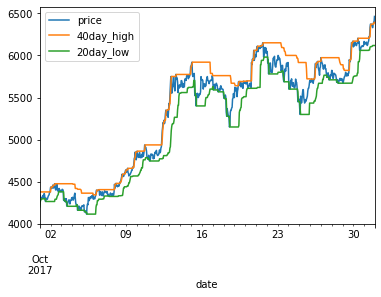

In [230]:
close.loc["2017-10", ["price", "40day_high", "20day_low"]].plot()

In [231]:
temp = close.copy()

In [232]:
np.where(close.price > close["40day_high"], 1, 0)

array([0, 0, 0, ..., 0, 1, 0])

In [233]:
temp["go_long"] = np.where(close.price.shift() > close["40day_high"].shift(), 1, 0)
temp["exit_long"] = np.where(close.price.shift() < close["20day_low"].shift(), 1 , 0)
temp

,price,40day_high,20day_low,go_long,exit_long
date,,,,,
2017-08-17 04:00:00,4308.83,NaN,NaN,0,0
2017-08-17 05:00:00,4315.32,NaN,NaN,0,0
2017-08-17 06:00:00,4324.35,NaN,NaN,0,0
2017-08-17 07:00:00,4349.99,NaN,NaN,0,0
2017-08-17 08:00:00,4360.69,NaN,NaN,0,0
...,...,...,...,...,...
2020-08-16 00:00:00,11811.51,11921.77,11749.33,0,0
2020-08-16 01:00:00,11890.57,11921.77,11749.33,0,0
2020-08-16 02:00:00,11869.08,11921.77,11749.33,0,0


In [234]:
trades = temp[(temp["go_long"]==1)|(temp["exit_long"]==1)]
trades

,price,40day_high,20day_low,go_long,exit_long
date,,,,,
2017-08-18 02:00:00,4267.59,NaN,4243.59,0,1
2017-08-18 16:00:00,4250.34,NaN,4236.89,0,1
2017-08-18 18:00:00,4117.41,NaN,4193.35,0,1
2017-08-18 19:00:00,4136.28,NaN,4117.41,0,1
2017-08-18 21:00:00,3975.69,4470.82,4021.11,0,1
...,...,...,...,...,...
2020-08-14 19:00:00,11801.94,11823.24,11668.96,1,0
2020-08-15 01:00:00,11921.77,11916.96,11668.96,1,0
2020-08-15 02:00:00,11889.00,11921.77,11668.96,1,0


In [235]:
trade_entries_exits = trades[(trades["go_long"].diff()==1)|(trades["exit_long"].diff()==1)]
trade_entries_exits[["go_long", "exit_long"]]

,go_long,exit_long
date,,
2017-08-23 02:00:00,1,0
2017-08-26 00:00:00,0,1
2017-08-29 00:00:00,1,0
2017-08-30 10:00:00,0,1
2017-08-31 11:00:00,1,0
...,...,...
2020-08-10 02:00:00,1,0
2020-08-11 09:00:00,0,1
2020-08-13 22:00:00,1,0


In [236]:
Buy_dates = trade_entries_exits[trade_entries_exits.go_long==1]
Sell_dates = trade_entries_exits[trade_entries_exits.exit_long==1]
len(Buy_dates), len(Sell_dates)

(270, 269)

In [237]:
if len(Buy_dates) > len(Sell_dates):
    Buy_dates.drop(Buy_dates.iloc[-1].name, axis=0, inplace=True)

C:\Users\mertk\AppData\Local\Temp\ipykernel_7836\3933760948.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Buy_dates.drop(Buy_dates.iloc[-1].name, axis=0, inplace=True)


In [238]:
Buy_dates

,price,40day_high,20day_low,go_long,exit_long
date,,,,,
2017-08-23 02:00:00,4083.72,4100.00,3794.12,1,0
2017-08-29 00:00:00,4349.44,4386.69,4169.01,1,0
2017-08-31 11:00:00,4656.67,4632.96,4536.82,1,0
2017-09-06 02:00:00,4446.00,4502.83,4013.46,1,0
2017-09-12 06:00:00,4366.00,4325.00,4164.52,1,0
...,...,...,...,...,...
2020-07-25 17:00:00,9688.49,9615.51,9533.92,1,0
2020-07-31 15:00:00,11346.90,11244.83,10977.08,1,0
2020-08-05 12:00:00,11562.86,11438.06,11165.36,1,0


In [239]:
Sell_dates

,price,40day_high,20day_low,go_long,exit_long
date,,,,,
2017-08-26 00:00:00,4281.00,4449.44,4280.68,0,1
2017-08-30 10:00:00,4477.10,4618.93,4482.00,0,1
2017-09-02 06:00:00,4696.44,4932.38,4473.35,0,1
2017-09-08 14:00:00,4238.12,4755.00,4353.05,0,1
2017-09-12 19:00:00,4165.50,4366.00,4094.25,0,1
...,...,...,...,...,...
2020-07-30 03:00:00,10983.56,11288.29,10977.09,0,1
2020-08-02 05:00:00,11252.14,12000.00,11169.84,0,1
2020-08-07 14:00:00,11630.56,11867.98,11737.98,0,1


In [256]:
inposition_dates_long = []

In [257]:
Buy_dates.iloc[0].name

Timestamp('2017-08-23 02:00:00')

In [258]:
for i in range(0, len(Buy_dates)):
    inposition_dates_long.append([Buy_dates.iloc[i].name, Sell_dates.iloc[i].name])

In [259]:
close

,price,40day_high,20day_low,long_position
date,,,,
2017-08-17 04:00:00,4308.83,NaN,NaN,0
2017-08-17 05:00:00,4315.32,NaN,NaN,0
2017-08-17 06:00:00,4324.35,NaN,NaN,0
2017-08-17 07:00:00,4349.99,NaN,NaN,0
2017-08-17 08:00:00,4360.69,NaN,NaN,0
...,...,...,...,...
2020-08-16 00:00:00,11811.51,11921.77,11749.33,0
2020-08-16 01:00:00,11890.57,11921.77,11749.33,0
2020-08-16 02:00:00,11869.08,11921.77,11749.33,0


In [260]:
inposition_dates_long[1]

[Timestamp('2017-08-29 00:00:00'), Timestamp('2017-08-30 10:00:00')]

In [261]:
close["long_position"] = 0
close

,price,40day_high,20day_low,long_position
date,,,,
2017-08-17 04:00:00,4308.83,NaN,NaN,0
2017-08-17 05:00:00,4315.32,NaN,NaN,0
2017-08-17 06:00:00,4324.35,NaN,NaN,0
2017-08-17 07:00:00,4349.99,NaN,NaN,0
2017-08-17 08:00:00,4360.69,NaN,NaN,0
...,...,...,...,...
2020-08-16 00:00:00,11811.51,11921.77,11749.33,0
2020-08-16 01:00:00,11890.57,11921.77,11749.33,0
2020-08-16 02:00:00,11869.08,11921.77,11749.33,0


In [262]:
temp = close.copy()

In [263]:
inposition_dates_long[1][0], inposition_dates_long[1][1]

(Timestamp('2017-08-29 00:00:00'), Timestamp('2017-08-30 10:00:00'))

In [265]:
for trade_duration in inposition_dates_long:
    close.loc[trade_duration[0]:trade_duration[1], "long_position"] = 1

In [274]:
close["log_returns"] = np.log(close.price.pct_change() + 1)
close["cumulative_log_returns"] = np.exp(close.log_returns.cumsum())

In [279]:
close["strategy_returns"] = close["log_returns"] * close.long_position
close["cumulative_strategy_returns"] = np.exp(close.strategy_returns.cumsum())

<AxesSubplot:xlabel='date'>

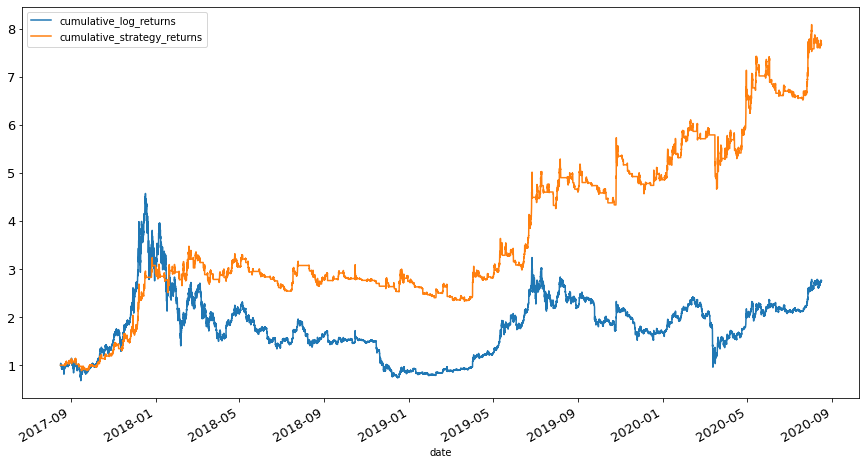

In [282]:
close[["cumulative_log_returns", "cumulative_strategy_returns"]].plot(figsize=(15,8), fontsize=13)

In [284]:
ann_mu_hold = close.log_returns.mean() * (365.25 * 24)
ann_std_hold = close.log_returns.std() * np.sqrt(365.25 * 24)

ann_mu_strategy = close.strategy_returns.mean() * (365.25 * 24)
ann_std_strategy = close.strategy_returns.std() * np.sqrt(365.25 * 24)

sharpe_hold = ann_mu_hold / ann_std_hold
sharpe_strategy = ann_mu_strategy / ann_std_strategy
sharpe_hold, sharpe_strategy

(0.36360457353269926, 1.3810882843740966)

### Remaking the strategy some things feel not right

In [290]:
close = data.close.to_frame().copy()
close.rename(columns={"close":"price"}, inplace=True)
close.price = pd.to_numeric(close.price)
close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26173 entries, 2017-08-17 04:00:00 to 2020-08-16 04:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   26173 non-null  float64
dtypes: float64(1)
memory usage: 1.4 MB


In [305]:
close

,price,40day_high,20day_low
date,,,
2017-08-17 04:00:00,4308.83,NaN,NaN
2017-08-17 05:00:00,4315.32,NaN,NaN
2017-08-17 06:00:00,4324.35,NaN,NaN
2017-08-17 07:00:00,4349.99,NaN,NaN
2017-08-17 08:00:00,4360.69,NaN,NaN
...,...,...,...
2020-08-16 00:00:00,11811.51,11921.77,11749.33
2020-08-16 01:00:00,11890.57,11921.77,11749.33
2020-08-16 02:00:00,11869.08,11921.77,11749.33


In [292]:
close["40day_high"] = (close.price.rolling(window=40).max()).shift()
close["20day_low"] = (close.price.rolling(window=20).min()).shift()
close

,price,40day_high,20day_low
date,,,
2017-08-17 04:00:00,4308.83,NaN,NaN
2017-08-17 05:00:00,4315.32,NaN,NaN
2017-08-17 06:00:00,4324.35,NaN,NaN
2017-08-17 07:00:00,4349.99,NaN,NaN
2017-08-17 08:00:00,4360.69,NaN,NaN
...,...,...,...
2020-08-16 00:00:00,11811.51,11921.77,11749.33
2020-08-16 01:00:00,11890.57,11921.77,11749.33
2020-08-16 02:00:00,11869.08,11921.77,11749.33


In [293]:
temp=close.copy()
temp["go_long"] = np.where(close.price.shift() > close["40day_high"].shift(), 1, 0)
temp["exit_long"] = np.where(close.price.shift() < close["20day_low"].shift(), 1 , 0)
temp

,price,40day_high,20day_low,go_long,exit_long
date,,,,,
2017-08-17 04:00:00,4308.83,NaN,NaN,0,0
2017-08-17 05:00:00,4315.32,NaN,NaN,0,0
2017-08-17 06:00:00,4324.35,NaN,NaN,0,0
2017-08-17 07:00:00,4349.99,NaN,NaN,0,0
2017-08-17 08:00:00,4360.69,NaN,NaN,0,0
...,...,...,...,...,...
2020-08-16 00:00:00,11811.51,11921.77,11749.33,0,0
2020-08-16 01:00:00,11890.57,11921.77,11749.33,0,0
2020-08-16 02:00:00,11869.08,11921.77,11749.33,0,0


In [306]:
trades = temp[(temp["go_long"]==1)|(temp["exit_long"]==1)]
trades

,price,40day_high,20day_low,go_long,exit_long
date,,,,,
2017-08-18 02:00:00,4267.59,NaN,4243.59,0,1
2017-08-18 16:00:00,4250.34,NaN,4236.89,0,1
2017-08-18 18:00:00,4117.41,NaN,4193.35,0,1
2017-08-18 19:00:00,4136.28,NaN,4117.41,0,1
2017-08-18 21:00:00,3975.69,4470.82,4021.11,0,1
...,...,...,...,...,...
2020-08-14 19:00:00,11801.94,11823.24,11668.96,1,0
2020-08-15 01:00:00,11921.77,11916.96,11668.96,1,0
2020-08-15 02:00:00,11889.00,11921.77,11668.96,1,0


In [307]:
trades = trades[(trades.go_long.diff()==1)|trades.exit_long.diff()==1]

In [332]:
trades

,price,40day_high,20day_low,go_long,exit_long
date,,,,,
2017-08-23 02:00:00,4083.72,4100.00,3794.12,1,0
2017-08-26 00:00:00,4281.00,4449.44,4280.68,0,1
2017-08-29 00:00:00,4349.44,4386.69,4169.01,1,0
2017-08-30 10:00:00,4477.10,4618.93,4482.00,0,1
2017-08-31 11:00:00,4656.67,4632.96,4536.82,1,0
...,...,...,...,...,...
2020-08-10 02:00:00,11996.46,11849.87,11526.92,1,0
2020-08-11 09:00:00,11695.90,12009.40,11712.94,0,1
2020-08-13 22:00:00,11717.70,11685.40,11402.63,1,0


In [339]:
trades.iloc[0].go_long

1.0

In [342]:
go_long_dates = []
exit_long_dates = []
inpos = False
for i in range(0, len(trades)):
    if trades.iloc[i].go_long == 1:
        if inpos==False:
            go_long_dates.append(trades.index[i])
            inpos=True
    if trades.iloc[i].exit_long == 1:
        if inpos==True:
            exit_long_dates.append(trades.index[i])
            inpos=False
len(go_long_dates), len(exit_long_dates)
# this code is important because there might be multiple signals to trade when in position
# for example, we are long and there comes another signal to go long before we go netural
# that would be a problem
# even without this code there isn't any problem but it's just pure chance

(270, 269)

## Let's do when 40 days low go short when 20 day's high exit short
### and combine 2 strategies together(with long strategy)

In [349]:
close = data.close.to_frame().copy()
close.rename(columns={"close":"price"}, inplace=True)
close["price"] = pd.to_numeric(close.price)
close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26173 entries, 2017-08-17 04:00:00 to 2020-08-16 04:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   26173 non-null  float64
dtypes: float64(1)
memory usage: 1.4 MB


In [350]:
close["40daylow"] = close.price.rolling(window=40).min().shift()
close["20dayhigh"] = close.price.rolling(window=20).max().shift()
close

,price,40daylow,20dayhigh
date,,,
2017-08-17 04:00:00,4308.83,NaN,NaN
2017-08-17 05:00:00,4315.32,NaN,NaN
2017-08-17 06:00:00,4324.35,NaN,NaN
2017-08-17 07:00:00,4349.99,NaN,NaN
2017-08-17 08:00:00,4360.69,NaN,NaN
...,...,...,...
2020-08-16 00:00:00,11811.51,11681.37,11896.07
2020-08-16 01:00:00,11890.57,11698.38,11896.07
2020-08-16 02:00:00,11869.08,11706.71,11896.07


In [352]:
trades_short = close.copy()
trades_short["go_short"] = np.where(trades_short.price.shift() < trades_short["40daylow"].shift(), 1, 0)
trades_short["exit_short"] = np.where(trades_short.price.shift() > trades_short["20dayhigh"].shift(), 1, 0)
trades_short

,price,40daylow,20dayhigh,go_short,exit_short
date,,,,,
2017-08-17 04:00:00,4308.83,NaN,NaN,0,0
2017-08-17 05:00:00,4315.32,NaN,NaN,0,0
2017-08-17 06:00:00,4324.35,NaN,NaN,0,0
2017-08-17 07:00:00,4349.99,NaN,NaN,0,0
2017-08-17 08:00:00,4360.69,NaN,NaN,0,0
...,...,...,...,...,...
2020-08-16 00:00:00,11811.51,11681.37,11896.07,0,0
2020-08-16 01:00:00,11890.57,11698.38,11896.07,0,0
2020-08-16 02:00:00,11869.08,11706.71,11896.07,0,0


In [353]:
trades_short = trades_short[(trades_short.go_short==1)|(trades_short.exit_short==1)]
trades_short

,price,40daylow,20dayhigh,go_short,exit_short
date,,,,,
2017-08-18 21:00:00,3975.69,4021.11,4356.31,1,0
2017-08-18 22:00:00,4113.75,3975.69,4356.31,1,0
2017-08-19 12:00:00,4095.00,3957.60,4250.34,1,0
2017-08-20 08:00:00,4184.73,3957.60,4155.87,0,1
2017-08-20 09:00:00,4155.00,3957.60,4184.73,0,1
...,...,...,...,...,...
2020-08-14 17:00:00,11787.66,11402.63,11809.85,0,1
2020-08-14 19:00:00,11801.94,11402.63,11823.24,0,1
2020-08-15 01:00:00,11921.77,11402.63,11916.96,0,1


In [354]:
trades_short = trades_short[(trades_short.go_short.diff()==1)|(trades_short.exit_short.diff()==1)]
trades_short

,price,40daylow,20dayhigh,go_short,exit_short
date,,,,,
2017-08-20 08:00:00,4184.73,3957.60,4155.87,0,1
2017-08-21 14:00:00,3989.17,3951.49,4169.98,1,0
2017-08-22 19:00:00,3984.24,3500.80,4043.76,0,1
2017-08-28 04:00:00,4227.00,4239.37,4370.00,1,0
2017-08-28 23:00:00,4386.69,4169.01,4353.32,0,1
...,...,...,...,...,...
2020-08-08 10:00:00,11738.55,11479.73,11742.15,0,1
2020-08-09 18:00:00,11634.34,11526.92,11761.41,1,0
2020-08-10 01:00:00,11849.87,11526.92,11739.08,0,1


In [361]:
go_short_dates = []
exit_short_dates = []
inpos = False
for i in range(0, len(trades_short)):
    if trades_short.iloc[i].go_short == 1:
        if inpos==False:
            go_short_dates.append(trades_short.index[i])
            inpos=True
    if trades_short.iloc[i].exit_short == 1:
        if inpos==True:
            exit_short_dates.append(trades_short.index[i])
            inpos=False
len(go_short_dates), len(exit_short_dates)

(244, 244)

In [364]:
inposition_dates_short = []

for i in range(0, len(go_short_dates)):
    inposition_dates_short.append([go_short_dates[i], exit_short_dates[i]])
inposition_dates_short

[[Timestamp('2017-08-21 14:00:00'), Timestamp('2017-08-22 19:00:00')],
 [Timestamp('2017-08-28 04:00:00'), Timestamp('2017-08-28 23:00:00')],
 [Timestamp('2017-09-02 06:00:00'), Timestamp('2017-09-03 05:00:00')],
 [Timestamp('2017-09-04 08:00:00'), Timestamp('2017-09-05 14:00:00')],
 [Timestamp('2017-09-08 14:00:00'), Timestamp('2017-09-10 20:00:00')],
 [Timestamp('2017-09-12 19:00:00'), Timestamp('2017-09-15 15:00:00')],
 [Timestamp('2017-09-21 01:00:00'), Timestamp('2017-09-23 05:00:00')],
 [Timestamp('2017-09-29 03:00:00'), Timestamp('2017-09-29 12:00:00')],
 [Timestamp('2017-10-03 08:00:00'), Timestamp('2017-10-04 02:00:00')],
 [Timestamp('2017-10-04 13:00:00'), Timestamp('2017-10-05 11:00:00')],
 [Timestamp('2017-10-15 09:00:00'), Timestamp('2017-10-16 13:00:00')],
 [Timestamp('2017-10-18 01:00:00'), Timestamp('2017-10-18 23:00:00')],
 [Timestamp('2017-10-23 13:00:00'), Timestamp('2017-10-25 21:00:00')],
 [Timestamp('2017-10-28 12:00:00'), Timestamp('2017-10-29 07:00:00')],
 [Time

In [367]:
close["short_position"] = 0
for trade_duration in inposition_dates_short:
    close.loc[trade_duration[0]:trade_duration[1], "short_position"] = 1

In [373]:
close["log_returns"] = np.log(close.price.pct_change() + 1)
close

,price,40daylow,20dayhigh,short_position,log_returns
date,,,,,
2017-08-17 04:00:00,4308.83,NaN,NaN,0,NaN
2017-08-17 05:00:00,4315.32,NaN,NaN,0,0.001505
2017-08-17 06:00:00,4324.35,NaN,NaN,0,0.002090
2017-08-17 07:00:00,4349.99,NaN,NaN,0,0.005912
2017-08-17 08:00:00,4360.69,NaN,NaN,0,0.002457
...,...,...,...,...,...
2020-08-16 00:00:00,11811.51,11681.37,11896.07,0,-0.003456
2020-08-16 01:00:00,11890.57,11698.38,11896.07,0,0.006671
2020-08-16 02:00:00,11869.08,11706.71,11896.07,0,-0.001809


In [374]:
close["cumulative_log_returns"] = close.log_returns.cumsum().apply(np.exp)
close

,price,40daylow,20dayhigh,short_position,log_returns,cumulative_log_returns
date,,,,,,
2017-08-17 04:00:00,4308.83,NaN,NaN,0,NaN,NaN
2017-08-17 05:00:00,4315.32,NaN,NaN,0,0.001505,1.001506
2017-08-17 06:00:00,4324.35,NaN,NaN,0,0.002090,1.003602
2017-08-17 07:00:00,4349.99,NaN,NaN,0,0.005912,1.009552
2017-08-17 08:00:00,4360.69,NaN,NaN,0,0.002457,1.012036
...,...,...,...,...,...,...
2020-08-16 00:00:00,11811.51,11681.37,11896.07,0,-0.003456,2.741234
2020-08-16 01:00:00,11890.57,11698.38,11896.07,0,0.006671,2.759582
2020-08-16 02:00:00,11869.08,11706.71,11896.07,0,-0.001809,2.754595


In [375]:
close["strategy_returns"] = close.short_position * (close.log_returns * -1)# we are short so when price falls we make profit accourdingly

In [379]:
close["cumulative_strategy_returns"] = close.strategy_returns.cumsum().apply(np.exp)
close

,price,40daylow,20dayhigh,short_position,log_returns,cumulative_log_returns,strategy_returns,cumulative_strategy_returns
date,,,,,,,,
2017-08-17 04:00:00,4308.83,NaN,NaN,0,NaN,NaN,NaN,NaN
2017-08-17 05:00:00,4315.32,NaN,NaN,0,0.001505,1.001506,-0.0,1.000000
2017-08-17 06:00:00,4324.35,NaN,NaN,0,0.002090,1.003602,-0.0,1.000000
2017-08-17 07:00:00,4349.99,NaN,NaN,0,0.005912,1.009552,-0.0,1.000000
2017-08-17 08:00:00,4360.69,NaN,NaN,0,0.002457,1.012036,-0.0,1.000000
...,...,...,...,...,...,...,...,...
2020-08-16 00:00:00,11811.51,11681.37,11896.07,0,-0.003456,2.741234,0.0,4.187412
2020-08-16 01:00:00,11890.57,11698.38,11896.07,0,0.006671,2.759582,-0.0,4.187412
2020-08-16 02:00:00,11869.08,11706.71,11896.07,0,-0.001809,2.754595,0.0,4.187412


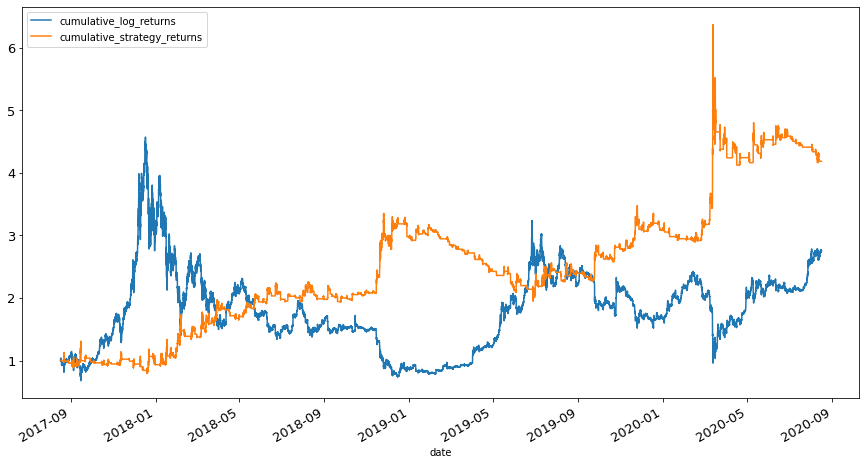

In [381]:
close[["cumulative_log_returns", "cumulative_strategy_returns"]].plot(figsize=(15,8), fontsize=13)
plt.legend()

In [383]:
ann_mu_strategy = close.strategy_returns.mean() * (365.25 * 24)
ann_std_strategy = close.strategy_returns.std() * np.sqrt(365.25 * 24)
ann_mu_strategy / ann_std_strategy

0.7198275981370752

In [86]:
temp = pd.DataFrame([[1,2,3], [3,4,6]])

In [87]:
temp

,0,1,2
0,1,2,3
1,3,4,6


In [89]:
temp[0].diff() + temp[1].diff()

0    NaN
1    4.0
dtype: float64

## Short/long channel breakout strategy free coding

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from binance.client import Client
from datetime import datetime, timedelta
%matplotlib inline

In [9]:
entry_signal = 40
exit_signal = 20
raw = pd.read_csv("BTCUSDT.csv")
raw = raw.loc[:"2020-08-08"]
close = raw.close.to_frame().copy()
close.rename(columns={"close":"price"}, inplace=True)
close["last_n_dayhigh_longtrade"] = close.price.rolling(window=entry_signal).max().shift()
close["last_n_daylow_longtrade"] = close.price.rolling(window=exit_signal).min().shift() 
close["last_n_daylow_shorttrade"] = close.price.rolling(window=entry_signal).min().shift()
close["last_n_dayhigh_shorttrade"] = close.price.rolling(window=exit_signal).max().shift()
temp = close.copy()
temp["long_entry"] = np.where(temp.price.shift() > temp["last_n_dayhigh_longtrade"].shift(), 1, 0)
temp["long_exit"] = np.where(temp.price.shift() < temp["last_n_daylow_longtrade"].shift(), 1, 0)
temp["short_entry"] = np.where(temp.price.shift() < temp["last_n_daylow_shorttrade"].shift(), 1, 0)
temp["short_exit"] = np.where(temp.price.shift() > temp["last_n_dayhigh_shorttrade"].shift(), 1, 0)
trades = temp[(temp.long_entry==1)|(temp.long_exit==1)|(temp.short_entry==1)|(temp.short_exit==1)]
trades = trades[(trades.long_entry.diff()==1)|(trades.long_exit.diff()==1)|(trades.short_entry.diff()==1)|(trades.short_exit.diff()==1)]
long_entry_dates = []
long_exit_dates = []
short_entry_dates = []
short_exit_dates = []
long_inpos=False
short_inpos=False
for i in range(0, len(trades)):
    if trades.iloc[i].long_entry==1:
        if long_inpos==False and short_inpos==False:
            long_entry_dates.append(trades.index[i])
            long_inpos=True
    if trades.iloc[i].long_exit==1:
        if long_inpos==True:
            long_exit_dates.append(trades.index[i])
            long_inpos=False
    if trades.iloc[i].short_entry==1:
        if long_inpos==False and short_inpos==False:
            short_entry_dates.append(trades.index[i])
            short_inpos=True
    if trades.iloc[i].short_exit==1:
        if short_inpos==True:
            short_exit_dates.append(trades.index[i])
            short_inpos=False
if len(long_entry_dates) > len(long_exit_dates):
    long_entry_dates.pop(-1)
if len(short_entry_dates) > len(short_exit_dates):
    short_entry_dates.pop(-1)
close["long_position"] = 0
close["short_position"] = 0
long_inposition_intervals = []
short_inposition_intervals = []
for i in range(len(long_entry_dates)):
    long_inposition_intervals.append([long_entry_dates[i], long_exit_dates[i]])
for long_inposition_interval in long_inposition_intervals:
    close.loc[long_inposition_interval[0]:long_inposition_interval[1], "long_position"] = 1
for i in range(len(short_entry_dates)):
    short_inposition_intervals.append([short_entry_dates[i], short_exit_dates[i]])
for short_inposition_interval in short_inposition_intervals:
    close.loc[short_inposition_interval[0]:short_inposition_interval[1], "short_position"] = 1
#commission = np.log(1 - 0.001) + np.log(1 - 0.0002)
close["log_ret"] = np.log(close.price.pct_change() + 1)
close["strategy_returns"] = (close.log_ret * close.long_position) + (-1 * close.log_ret * close.short_position)
close["trades"] = (close.long_position + close.short_position).to_frame().diff()
close.loc[close.trades!=1, "trades"] = 0
close["strategy_returns_wcomissions"] = close.strategy_returns - (close.trades * commission)
close

,price,last_n_dayhigh_longtrade,last_n_daylow_longtrade,last_n_daylow_shorttrade,last_n_dayhigh_shorttrade,long_position,short_position,log_ret,strategy_returns,trades,strategy_returns_wcomissions
0,4308.83,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0.0,NaN
1,4315.32,NaN,NaN,NaN,NaN,0,0,0.001505,0.000000,0.0,0.000000
2,4324.35,NaN,NaN,NaN,NaN,0,0,0.002090,0.000000,0.0,0.000000
3,4349.99,NaN,NaN,NaN,NaN,0,0,0.005912,0.000000,0.0,0.000000
4,4360.69,NaN,NaN,NaN,NaN,0,0,0.002457,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
20195,7234.13,7542.02,7290.92,7290.92,7382.63,0,0,-0.007820,0.000000,0.0,0.000000
20196,7232.52,7542.02,7234.13,7234.13,7382.63,0,0,-0.000223,0.000000,0.0,0.000000
20197,7182.35,7542.02,7232.52,7232.52,7382.63,0,0,-0.006961,0.000000,0.0,0.000000
20198,7226.35,7542.02,7182.35,7182.35,7382.63,0,0,0.006107,0.000000,0.0,0.000000


In [172]:
entry_signal = 200
exit_signal = 30
raw = pd.read_csv("BTCUSDT.csv", parse_dates=[0])
raw.set_index("date", inplace=True)
raw = raw.loc["2020-08-17":]
close = raw.close.to_frame().copy()
close.rename(columns={"close":"price"}, inplace=True)
close

,price
date,
2020-08-17 00:00:00,11845.31
2020-08-17 01:00:00,11843.63
2020-08-17 02:00:00,11860.27
2020-08-17 03:00:00,11844.71
2020-08-17 04:00:00,11809.38
...,...
2022-09-08 14:00:00,19315.83
2022-09-08 15:00:00,19250.81
2022-09-08 16:00:00,19189.80


In [173]:
close["last_n_dayhigh_longtrade"] = close.price.rolling(window=entry_signal).max().shift()
close["last_n_daylow_longtrade"] = close.price.rolling(window=exit_signal).min().shift() 
close["last_n_daylow_shorttrade"] = close.price.rolling(window=entry_signal).min().shift()
close["last_n_dayhigh_shorttrade"] = close.price.rolling(window=exit_signal).max().shift()

In [174]:
temp = close.copy()
temp["long_entry"] = np.where(temp.price.shift() > temp["last_n_dayhigh_longtrade"].shift(), 1, 0)
temp["long_exit"] = np.where(temp.price.shift() < temp["last_n_daylow_longtrade"].shift(), 1, 0)
temp["short_entry"] = np.where(temp.price.shift() < temp["last_n_daylow_shorttrade"].shift(), 1, 0)
temp["short_exit"] = np.where(temp.price.shift() > temp["last_n_dayhigh_shorttrade"].shift(), 1, 0)

In [175]:
trades = pd.DataFrame()
trades[["long_entry", "long_exit", "short_entry", "short_exit"]] = temp.loc[(temp.long_entry==1)|(temp.short_entry==1)|(temp.long_exit==1)|(temp.short_exit==1), ["long_entry", "long_exit", "short_entry", "short_exit"]]
trades

,long_entry,long_exit,short_entry,short_exit
date,,,,
2020-08-19 03:00:00,0,1,0,0
2020-08-19 04:00:00,0,1,0,0
2020-08-19 05:00:00,0,1,0,0
2020-08-19 06:00:00,0,1,0,0
2020-08-19 20:00:00,0,1,0,0
...,...,...,...,...
2022-09-06 19:00:00,0,1,1,0
2022-09-06 20:00:00,0,1,1,0
2022-09-07 00:00:00,0,1,1,0


In [176]:
trades = trades[(trades.long_entry.diff()==1)|(trades.short_entry.diff()==1)|(trades.long_exit.diff()==1)|(trades.short_exit.diff()==1)]

In [177]:
long_entry_dates = []
long_exit_dates = []
short_entry_dates = []
short_exit_dates = []
long_inpos = False
short_inpos = False
for i in range(len(trades)):
    if trades.iloc[i].long_entry==1:
        if not long_inpos and not short_inpos:
            long_entry_dates.append(trades.index[i])
            long_inpos=True
    if trades.iloc[i].long_exit==1:
        if long_inpos:
            long_exit_dates.append(trades.index[i])
            long_inpos=False
    if trades.iloc[i].short_entry==1:
        if not long_inpos and not short_inpos:
            short_entry_dates.append(trades.index[i])
            short_inpos=True
    if trades.iloc[i].short_exit==1:
        if short_inpos:
            short_exit_dates.append(trades.index[i])
            short_inpos=False


In [178]:
if len(long_entry_dates) > len(long_exit_dates):
    long_entry_dates.pop(-1)
if len(short_entry_dates) > len(short_exit_dates):
    short_entry_dates.pop(-1)

In [179]:
long_inpos_intervals = []
short_inpos_intervals = []

for i in range(len(long_entry_dates)):
    long_inpos_intervals.append([long_entry_dates[i], long_exit_dates[i]])
for i in range(len(short_entry_dates)):
    short_inpos_intervals.append([short_entry_dates[i], short_exit_dates[i]])
close["long_position"] = 0
close["short_position"] = 0
for long_inpos_interval in long_inpos_intervals:
    close.loc[long_inpos_interval[0]:long_inpos_interval[1], "long_position"] = 1 
for short_inpos_interval in short_inpos_intervals:
    close.loc[short_inpos_interval[0]:short_inpos_interval[1], "short_position"] = 1 
close

,price,last_n_dayhigh_longtrade,last_n_daylow_longtrade,last_n_daylow_shorttrade,last_n_dayhigh_shorttrade,long_position,short_position
date,,,,,,,
2020-08-17 00:00:00,11845.31,NaN,NaN,NaN,NaN,0,0
2020-08-17 01:00:00,11843.63,NaN,NaN,NaN,NaN,0,0
2020-08-17 02:00:00,11860.27,NaN,NaN,NaN,NaN,0,0
2020-08-17 03:00:00,11844.71,NaN,NaN,NaN,NaN,0,0
2020-08-17 04:00:00,11809.38,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...
2022-09-08 14:00:00,19315.83,20362.19,18739.59,18611.13,19387.62,0,0
2022-09-08 15:00:00,19250.81,20362.19,18739.59,18611.13,19387.62,0,0
2022-09-08 16:00:00,19189.80,20362.19,18739.59,18611.13,19387.62,0,0


In [180]:
close["log_ret"] = np.log(close.price.pct_change() + 1)
close["strategy_ret"] = (close.log_ret * close.long_position) + (-1 * close.log_ret * close.short_position)

<AxesSubplot:xlabel='date'>

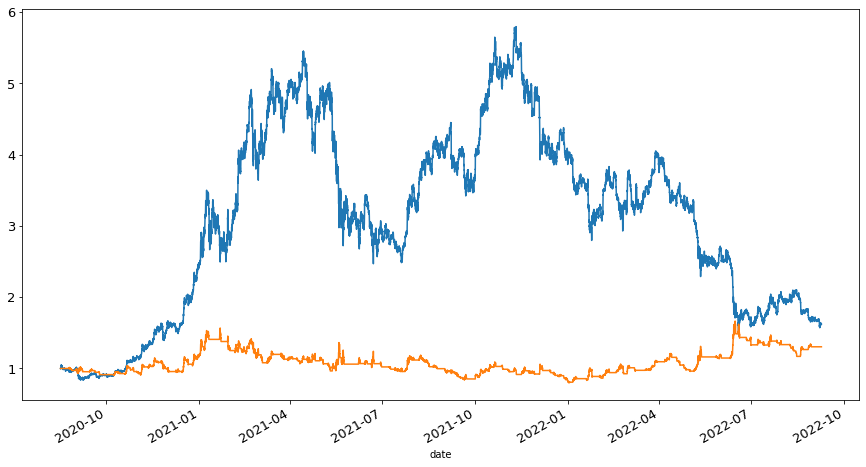

In [181]:
np.exp(close.log_ret.cumsum()).plot(figsize=(15,8), fontsize=13)
np.exp(close.strategy_ret.cumsum()).plot()

In [182]:
mu = close.strategy_ret.mean() * 365.25 * 24
std =  close.strategy_ret.std() * np.sqrt(365.25 * 24)
mu / std

0.2428289550424998

<AxesSubplot:xlabel='date'>

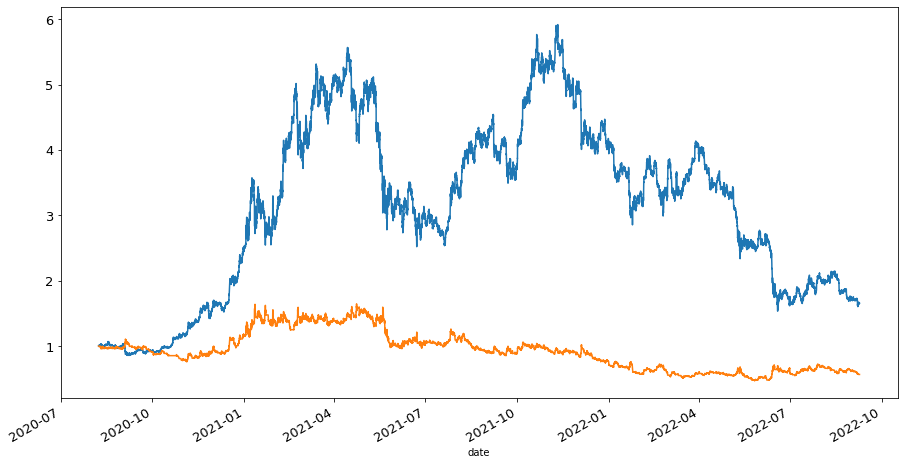

In [116]:
np.exp(close.log_ret.cumsum()).plot(figsize=(15,8), fontsize=13)
np.exp(close.strategy_ret.cumsum()).plot()